# Numerical Simulation Laboratory (NSL)
## Numerical exercises 10
### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

## <span style="color:purple"> Solution Exercise 10.1</span>

### Problem's Theory:
A parallel computer is a collection of computing elements able to communicate and to cooperate in order to solve quickly large computational tasks.\
In parallel programming the CPUs work in parallel, so, when don't communicate, do the same thing together. The idea behind parallel computing is that if the comutations are correctly distributed on CPUs, that communicate in a proper way, the algorithm will be more efficient than the algorithm non parallelized.\
In the optimization of a parallel calculation a good compromise is to maximize the product $E_p\times S_p$ where $E_p$ is the efficiency defined as $E_p=\frac{T_1}{p\times T_p}$ and $S_P=\frac{T_1}{T_p}$.
The **MPI** is a standard library developed to permits parallelization of algorithms for different programming languages. 
### Problem's approach:
In this exercise I have parallelized the Genetic Algorithm code. To do so i have used:
- `MPI_init()`: It defines an MPI environment.
- `MPI_Comm_size()`: return the number of processes belonging to MPI_Comm_World().
- `MPI_Comm_rank()`: returns the rank of the process within the communicator given as the first argument.
- `MPI_Barrier()`: Blocks the run of the code until all processes in the communicator have reached this routine.
- `MPI_Gather()`: transmits data from all the processes in the communicator to a single receiving process.
- `MPI_Send()`: transmits data from a process in the communicator to a single receiving process.
- `MPI_Recv()`: Receeive data from a process in the communicator to a single receiving process.
With this commands I have started 4 genetics algorithm in parallel. At the end of every cycle I have merged the best individues in the `MASTER_rank`  shuffled them and send to the different processes, in this way every process works with the best elements of every continent.

### Code:
- The idea of the code is that every 10 epochs make a migration. During the migration every process fill a vector of integers called `buffer` with the best individue found. Secondly a vector global buffer is created with dimension $dim_{global_buffer}=dim_{buffer}\times N_{precesses}$ where: $dim_{global_buffer}$  is the dimension of the vector global buffer ,$dim_{buffer}$ is the dimension of the vector buffer and $N_{precesses}$ is the number of the parallel processes.
- Created the vectors `MPI_Gather()` is called and every buffer is sent to every process. In the `MASTER_rank` is created a matrix $N_{preocesses}\times dim_{buffer}$ where the order of the rows is shuffled so that each buffer is related to a different rank. 
- Finally, I have sent each buffer to a process with the commands `MPI_Send()` and `MPI_Recv()`
- Main file for the parallel execution of the Genetic Algorithm:
```cpp
        for(int i=0;i<iterations;i++){   
        // Save results
        pop.Selection();
        pop.Mutation(0.65, 0.1, 0.1, 0.1, 0.1);
        pop.checkPopulation();
        
        // migration of the best individuals
        if(i%10==0 and migration){
            buffer.clear();
            global_buffer.clear(); 
            pop.sort();
            for(int j=0;j<indi_dim;j++){buffer.push_back(pop[0].get_idxs(j));}
            global_buffer.resize(size*buffer.size());
            
            // Gather the buffer
            MPI_Gather(&buffer[0], buffer.size(), MPI_INT, &global_buffer[0], buffer.size(), MPI_INT, MASTER, MPI_COMM_WORLD);
            MPI_Barrier(MPI_COMM_WORLD);
            if(rank==MASTER){ 
                
                // Create a vector of indexes shuffled
                ivec idxs(size);
                for(int j=0;j<size;j++){idxs(j)=j;}
                idxs=shuffle(idxs);

                // Create a matrix to store the best individuals
                vector<vector<int>> matrix(size, vector<int>(indi_dim));

                // Store the best individuals in the matrix with the indexes shuffled
                for(int j=0;j<size;j++){
                    for(int k=0;k<indi_dim;k++){
                        matrix[idxs[j]][k]=global_buffer[j*indi_dim+k];
                    }
                }
                
                // Send the best individuals to the other processes
                vector<int> helper;
                for(int j=0;j<size;j++){
                    helper.clear();
                    for(int k=0;k<indi_dim;k++){helper.push_back(matrix[j][k]);}
                    if(j==MASTER){buffer=helper;}
                    else{MPI_Send(&helper[0], helper.size(), MPI_INT, j, 0, MPI_COMM_WORLD);}
                }
            }
            if(rank!=MASTER){MPI_Recv(&buffer[0], buffer.size(), MPI_INT, MASTER, 0, MPI_COMM_WORLD, &stat1);}
        }
    }
```

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## <span style="color:purple"> Solution Exercise 10.2</span>

### Problem's approach:
To apply the parallel code to the TSP problem for 110 italian "capoluoghi di provincia" I have created a function to `get_coordinates` that takes in input a filename and read the coordinates of the citiesìs coordiantes in the file and return a matrix. Then I have added a method `Initialize_city` that read the coordinated of the cities that are contained in the matrix and create a population of individues.
To analize the differences between a parallelized or not parallelized algorithm I have run tow simulations with and without migration for a population on a circumference, in a square and for the 110 italian cities.
I have compared the losses of each pair of simulations and the GIFs composed by the evolution of the best path during the training process.
### Simulations parameters:
The parameters used for the **circle** and **square** simulation are:
- $N_{\text{individues}}=250$
- $N_{\text{epochs}}=500$
- $N_{\text{cities}}=34$

The hyperparameters used for mutations are: 
- Exponent of the power law distribution for selection $= 6$
- crossover probability $= 0.65$
- mutations probability $= 0.1$

The parameters used for the **cities** simulation are:
- $N_{\text{epochs}}=1500$
- $N_{\text{cities}}=110$

The hyperparameters used for mutations are: 
- $N_{\text{individues}}=700$
- Exponent of the power law distribution for selection $= 6$
- crossover probability $= 0.65$
- mutations probability $= 0.1$

When migration is performed is called every 10 epochs.

### Code:
function to get the coordinates:
```cpp
arma::mat get_coordinates(std::string filename) {
    arma::mat coordinates;
    // Open input file
    std::ifstream infile(filename);
    // verify that the file was opened correctly
    if (!infile.is_open()) {
        std::cerr << "Error: unable to open the file " << filename << std::endl;
        exit(-1);
    }
    // count the number of lines in the file
    int n = 0;
    std::string line;
    while (std::getline(infile, line)) {
        n++;
    }
    // reset the file to the beginning
    infile.clear();
    infile.seekg(0, std::ios::beg);
    // create a matrix to store the coordinates
    coordinates.set_size(n, 2);
    // read the coordinates from the file
    int i = 0;
    while (std::getline(infile, line)) {
        std::stringstream ss(line);
        double x, y;
        // read the coordinates
        if (ss >> x >> y) {
            coordinates(i, 0) = x;
            coordinates(i, 1) = y;
            i++;
        } else {
            std::cerr << "Error: bad row in the file: " << line << std::endl;
            exit(-1);
        }
    }
    // close the file
    infile.close();
    return coordinates;
}
```
- `Initialize_city` method in `Individue` :
```cpp
    // initialization of individue given the coordinates
    void initialize_city(int dim_indi,arma::mat coordinates,Random &rnd) {
        _rnd = &rnd;
        _dim=dim_indi;
        _indi.set_size(_dim);
        for(size_t i=0;i<_dim;i++){_indi(i)=i;}
        for(size_t i = 0; i < _dim; ++i) {
            _indi_map[i]={coordinates(i,0),coordinates(i,1)};
        }
    }
```cpp
- `Initialize_city` method in `Population` :
    // Initialization of the population given the coordinates
    void initialize_city(int dim_indi, int dim_pop, arma::mat &coordinates,Random &rnd) {
        _dim_indi=dim_indi;
        _dim_pop=dim_pop;
        _rnd=&rnd;
        pop.set_size(_dim_pop);
        pop[0].initialize_city(dim_indi,coordinates,*_rnd);
        for(size_t i = 0; i < _dim_pop; ++i) {
            pop[i] = pop[0];
            pop[i].shuffleidxs();
        }
    }
```

### Results
As shown in the following GIFs and plots, the Genetic Algorithm (GA) with migration performs better for a population of 34 cities arranged in either a circumference or a square. Although the final loss is the same, the convergence is faster with migration. In more complex scenarios, such as the arrangement of 110 Italian provincial capitals, the GA with migration not only converges faster but also achieves a lower loss value.
- Circle:
    - Best loss with  migration  = 6.22525
    - Best loss withou migration = 6.22525
- Square:
    - Best loss with  migration  = 10.1457
    - Best loss withou migration = 10.2544 
- Italy:
    - Best loss with  migration  =  70.4068
    - Best loss without migration = 77.6156

#### Circle losses and GIF

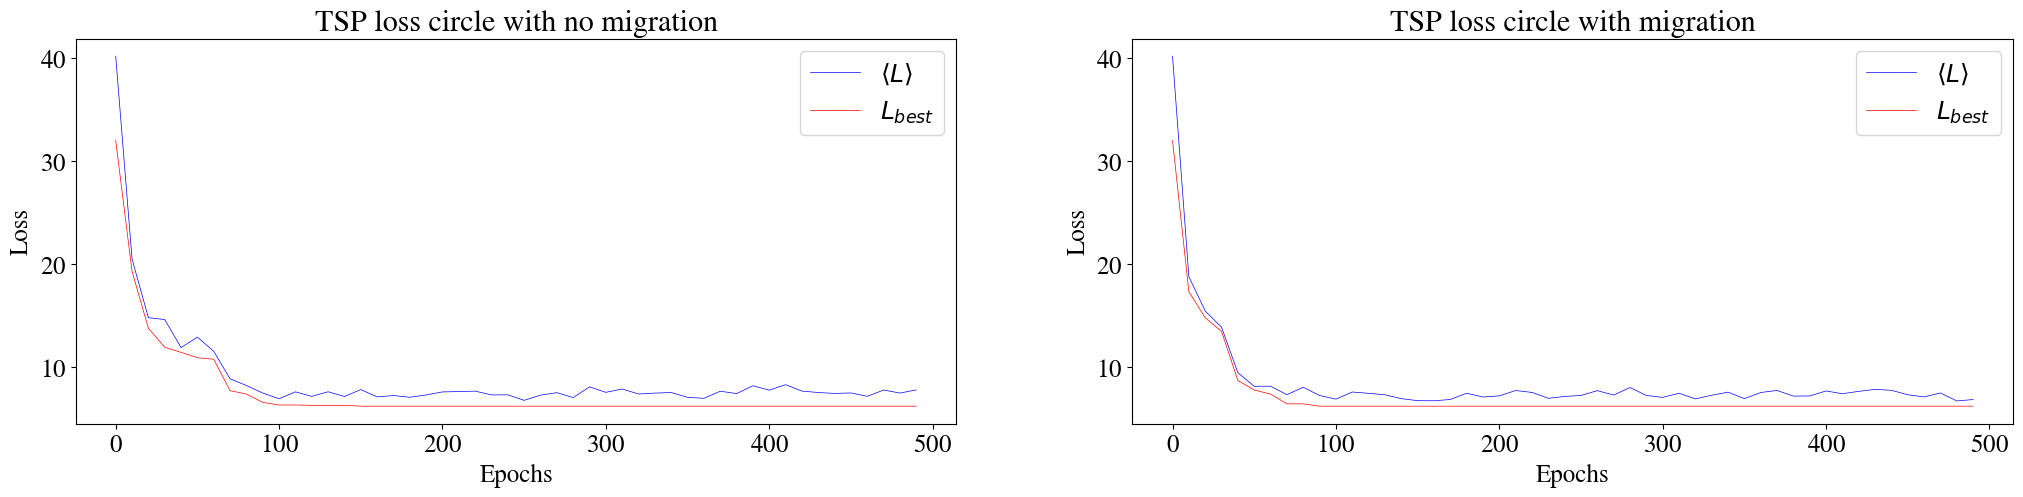

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'STIXGeneral','font.size':'18','axes.formatter.use_mathtext':'True'})
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
# Leggi il file CSV
data = np.loadtxt('../lecture_10/Results/circle_losses_migration_0.csv', delimiter=';',skiprows=1)
data2 = np.loadtxt('../lecture_10/Results/circle_losses_migration_1.csv', delimiter=';',skiprows=1)
# Estrai le coordinate x e y

# Collega i punti con una linea
ax[0].plot(data[:,0],data[:,1], color='blue', linestyle='-', linewidth=0.5,label=r'$\left<L\right>$')
ax[0].plot(data[:,0],data[:,2], color='red', linestyle='-', linewidth=0.5,label=r'$L_{best}$')
ax[1].plot(data2[:,0],data2[:,1], color='blue', linestyle='-', linewidth=0.5,label=r'$\left<L\right>$')
ax[1].plot(data2[:,0],data2[:,2], color='red', linestyle='-', linewidth=0.5,label=r'$L_{best}$')

# Aggiungi etichette e titolo
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('TSP loss circle with no migration')
ax[0].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('TSP loss circle with migration')
ax[1].legend()
# Mostra il grafico
plt.show()

##### GIF of the parallel search for cities on a circumference

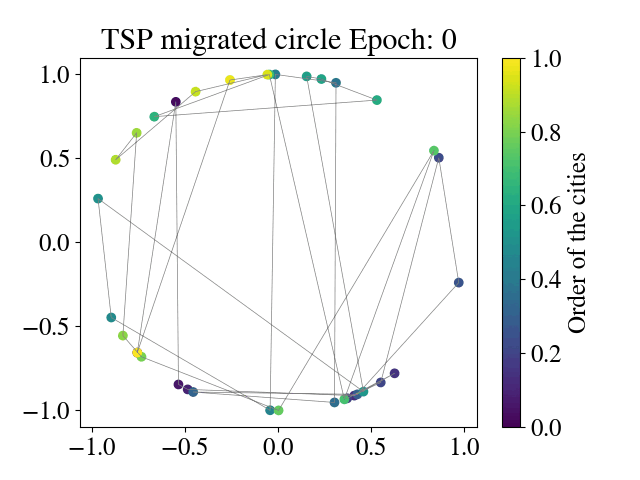

In [24]:
from IPython.display import Image

# Display the GIF
Image(filename='../lecture_10/Results/circle_parall.gif')

#### Square losses and GIF

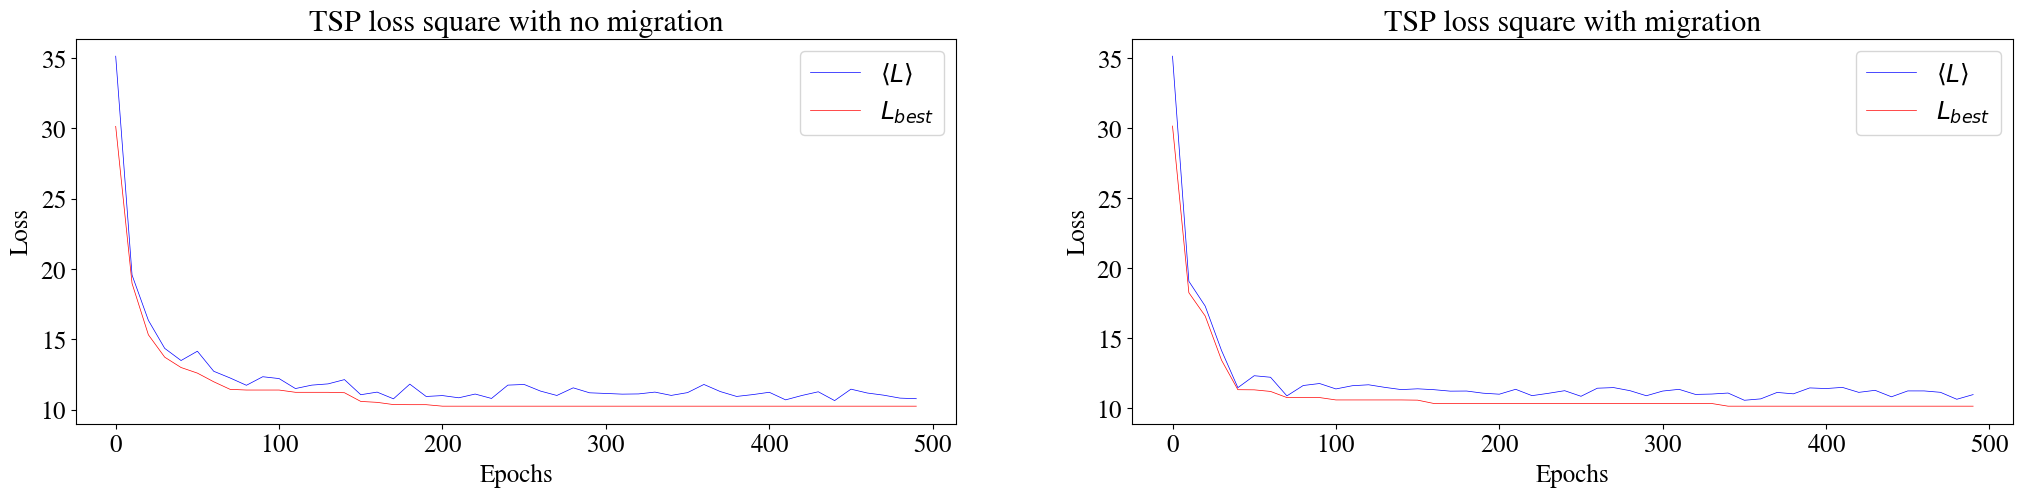

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'STIXGeneral','font.size':'18','axes.formatter.use_mathtext':'True'})
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
# Leggi il file CSV
data = np.loadtxt('../lecture_10/Results/square_losses_0.csv', delimiter=';',skiprows=1)
data2 = np.loadtxt('../lecture_10/Results/square_losses_1.csv', delimiter=';',skiprows=1)
# Estrai le coordinate x e y

# Collega i punti con una linea
ax[0].plot(data[:,0],data[:,1], color='blue', linestyle='-', linewidth=0.5,label=r'$\left<L\right>$')
ax[0].plot(data[:,0],data[:,2], color='red', linestyle='-', linewidth=0.5,label=r'$L_{best}$')
ax[1].plot(data2[:,0],data2[:,1], color='blue', linestyle='-', linewidth=0.5,label=r'$\left<L\right>$')
ax[1].plot(data2[:,0],data2[:,2], color='red', linestyle='-', linewidth=0.5,label=r'$L_{best}$')

# Aggiungi etichette e titolo
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('TSP loss square with no migration')
ax[0].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('TSP loss square with migration')
ax[1].legend()
# Mostra il grafico
plt.show()

##### GIF of the parallel search for cities in a square

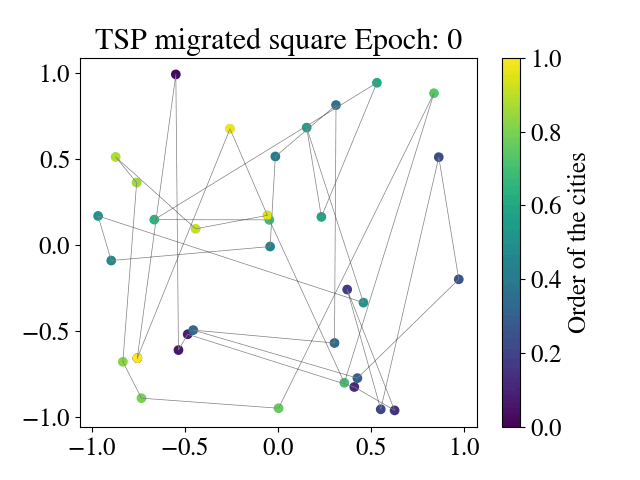

In [26]:
from IPython.display import Image

# Display the GIF
Image(filename='../lecture_10/Results/square_parall.gif')

#### Italian Cities losses and GIFs

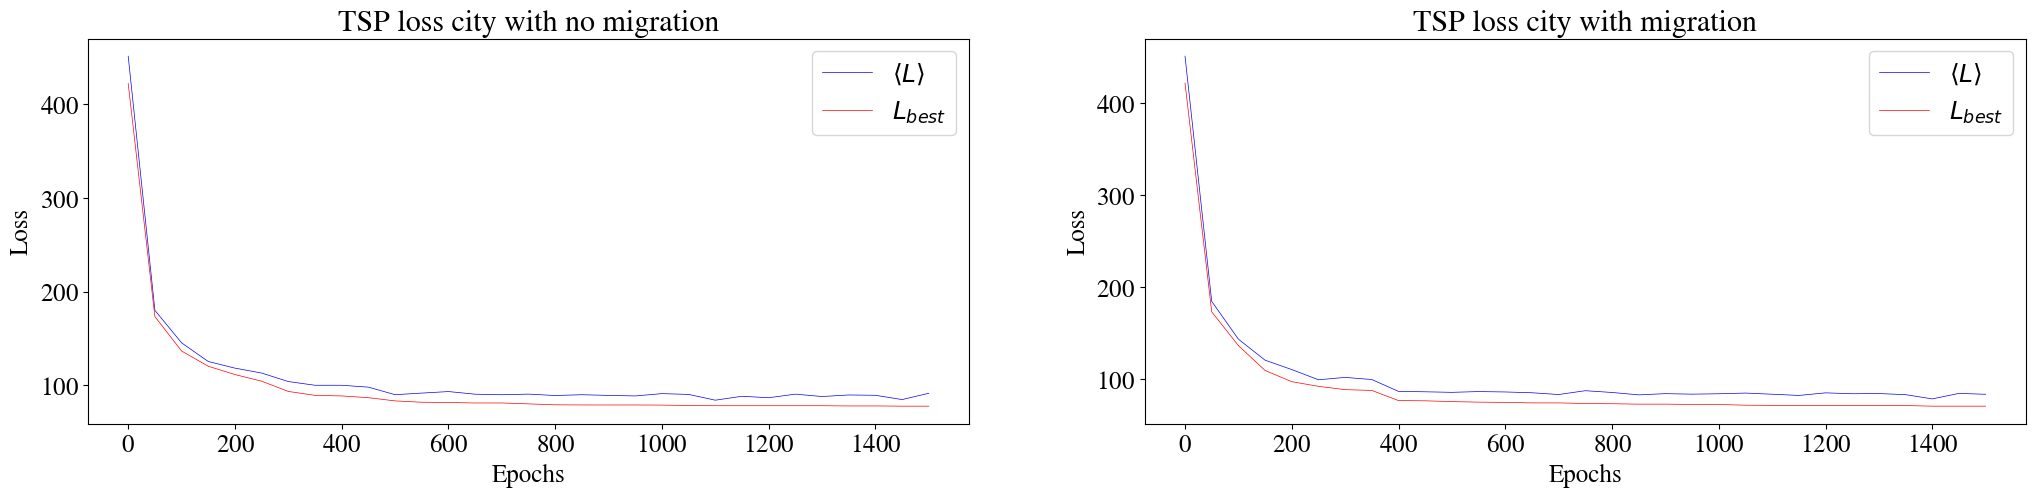

In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'STIXGeneral','font.size':'18','axes.formatter.use_mathtext':'True'})
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
# Leggi il file CSV
data = np.loadtxt('../lecture_10/Results/city_losses_migration_0.csv', delimiter=';',skiprows=1)
data2 = np.loadtxt('../lecture_10/Results/city_losses_migration_1.csv', delimiter=';',skiprows=1)
# Estrai le coordinate x e y

# Collega i punti con una linea
ax[0].plot(data[:,0],data[:,1], color='blue', linestyle='-', linewidth=0.5,label=r'$\left<L\right>$')
ax[0].plot(data[:,0],data[:,2], color='red', linestyle='-', linewidth=0.5,label=r'$L_{best}$')
ax[1].plot(data2[:,0],data2[:,1], color='blue', linestyle='-', linewidth=0.5,label=r'$\left<L\right>$')
ax[1].plot(data2[:,0],data2[:,2], color='red', linestyle='-', linewidth=0.5,label=r'$L_{best}$')

# Aggiungi etichette e titolo
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('TSP loss city with no migration')
ax[0].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('TSP loss city with migration')
ax[1].legend()
# Mostra il grafico
plt.show()

##### GIF of the search with and without migrations for italian cities


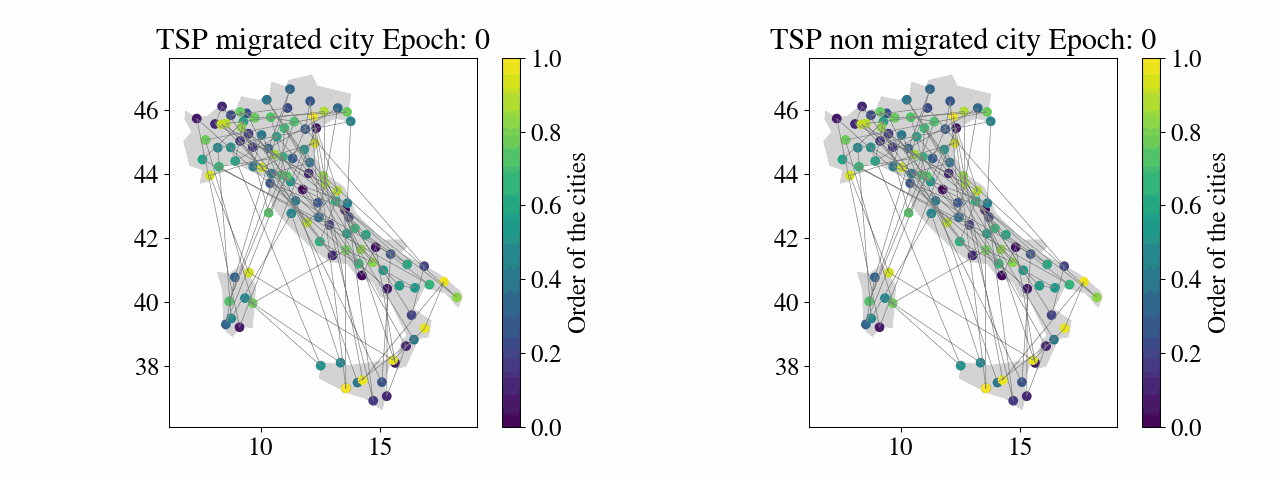

In [28]:
from IPython.display import Image
from PIL import Image as PILImage, ImageSequence

# Percorsi delle due GIF
path_gif1 = '../lecture_10/Results/city_parall.gif'
path_gif2 = '../lecture_10/Results/city.gif'

# Apri le due GIF
gif1 = PILImage.open(path_gif1)
gif2 = PILImage.open(path_gif2)

# Crea una lista per contenere i frame combinati
frames = []

# Trova il numero massimo di frame tra le due GIF
max_frames = max(gif1.n_frames, gif2.n_frames)

# Crea i frame combinati, allineando le GIF frame per frame
for i in range(max_frames):
    # Vai al frame `i` di ogni GIF (usa l'ultimo frame se la GIF è più corta)
    gif1.seek(i % gif1.n_frames)
    gif2.seek(i % gif2.n_frames)
    
    # Crea un'immagine combinata per ogni coppia di frame
    combined_frame = PILImage.new("RGBA", (gif1.width + gif2.width, max(gif1.height, gif2.height)))
    combined_frame.paste(gif1, (0, 0))
    combined_frame.paste(gif2, (gif1.width, 0))
    
    # Aggiungi il frame combinato alla lista
    frames.append(combined_frame)

# Salva tutti i frame come una nuova GIF animata
frames[0].save("../lecture_10/Results/combined_gif.gif", save_all=True, append_images=frames[1:], duration=gif1.info['duration'], loop=0)

# Visualizza la GIF combinata nel notebook
display(Image(filename="../lecture_10/Results/combined_gif.gif"))



### Code for the creation of the files.png
```python
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
plt.rcParams.update({'font.family': 'STIXGeneral','font.size':'18','axes.formatter.use_mathtext':'True'})
# read the file CSV
string_pattern=['city']
num_vec=np.arange(0,1550,50)
string_vec=num_vec.astype(str)
for pattern in string_pattern:
    for gen in string_vec:
        data = np.loadtxt('../lecture_10/Results/matrix_'+pattern+'_'+gen+'migration_0.csv', delimiter=',')
        # Download the Natural Earth countries dataset (110m scale)
        world = gpd.read_file("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson")
        # Use the correct column to filter for Italy
        ax = world[world['ADMIN'] == "Italy"].plot(color="lightgray")
        # Extract the x and y coordinates
        x = data[0,:]
        y = data[1,:]
        x = np.append(x, x[0])
        y = np.append(y, y[0])
        # Create a color gradient
        colors = np.linspace(0, 1, len(x))
        # Crea un colormap
        cmap = plt.get_cmap('viridis')
        # Create a scatter
        sc = plt.scatter(x, y, c=colors, cmap=cmap)
        # Connect the dots with a line
        plt.plot(x, y, color='gray', linestyle='-', linewidth=0.5)
        # Add a colorbar
        plt.colorbar(sc, label='Order of the cities')
        # Add labels and title
        plt.title('TSP non migrated '+pattern+' Epoch: '+gen)
        plt.savefig('../lecture_10/Results/png_files/'+pattern+'_files/'+gen+'_'+pattern+'.png')
        plt.close()
```